# Лабораторная на кластеризацию |

В ходе этой работы мы проведём кластеризацию MNIST подобных данных методом главных компонент и K-Means кластеризации

## Импортируем библиотеки

In [16]:
from scipy.io import arff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Получаем данные, проводим анализ

### Скачиваем файл Fashion-MNIST и закидываем его в pandas (заменяя коды классов обычными строковыми названиями)

In [2]:
data = arff.loadarff('./data/data.arff')
df = pd.DataFrame(data[0], columns=data[1])

fashion_mnist_labels = {
    '0': 'T-shirt/top',
    '1': 'Trouser',
    '2': 'Pullover',
    '3': 'Dress',
    '4': 'Coat',
    '5': 'Sandal',
    '6': 'Shirt',
    '7': 'Sneaker',
    '8': 'Bag',
    '9': 'Ankle boot'
}
df['class'] = df['class'].str.decode('utf-8').map(fashion_mnist_labels)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 785 entries, pixel1 to class
dtypes: float64(784), object(1)
memory usage: 419.2+ MB
None


### Применяем метод уменьшения размерности, предварительно стандартизировав данные

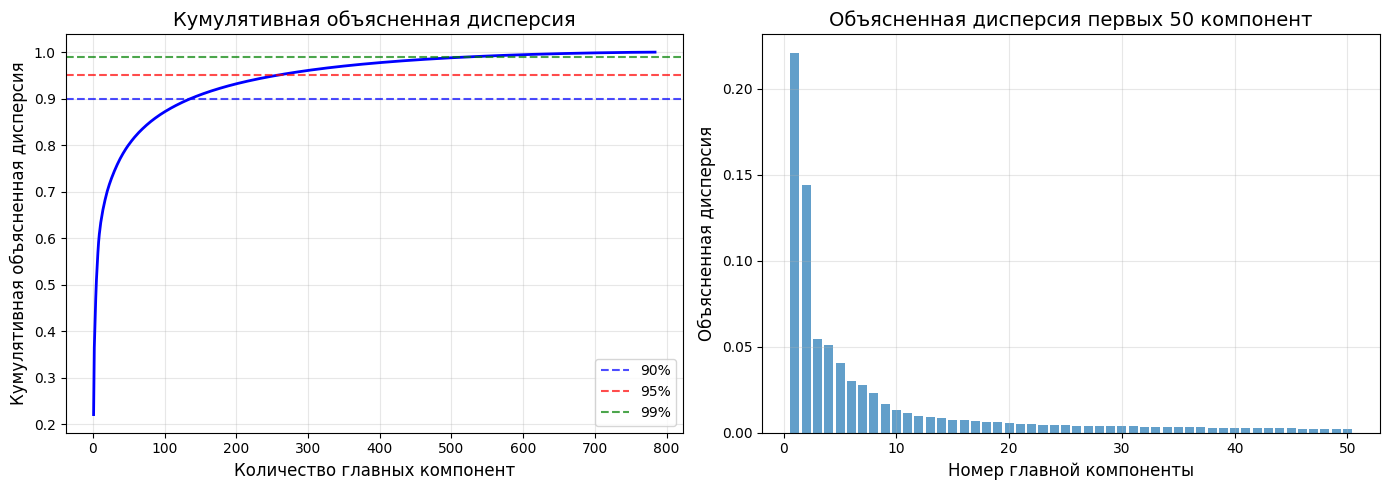

In [27]:
# Разделяем данные на признаки и целевую переменную
X = df.drop('class', axis=1)
y = df['class']

# Стандартизируем
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Применение PCA
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Визуализация объясненной дисперсии
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График кумулятивной дисперсии
axes[0].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'b-', linewidth=2)
axes[0].set_xlabel('Количество главных компонент', fontsize=12)
axes[0].set_ylabel('Кумулятивная объясненная дисперсия', fontsize=12)
axes[0].set_title('Кумулятивная объясненная дисперсия', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95%')
axes[0].axhline(y=0.99, color='g', linestyle='--', alpha=0.7, label='99%')
axes[0].legend()

n_components_show = min(50, len(explained_variance_ratio))
axes[1].bar(range(1, n_components_show + 1), explained_variance_ratio[:n_components_show], alpha=0.7)
axes[1].set_xlabel('Номер главной компоненты', fontsize=12)
axes[1].set_ylabel('Объясненная дисперсия', fontsize=12)
axes[1].set_title(f'Объясненная дисперсия первых {n_components_show} компонент', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Посчитаем оптимальное число компонент путем взятия 95% дисперсии

In [40]:
threshold_95 = 0.95
n_components_95 = np.argmax(cumulative_variance >= threshold_95) + 1

pca_95 = PCA(n_components=n_components_95)
X_pca_95 = pca_95.fit_transform(X_scaled)

print(f"Компонент для 95% дисперсии: {n_components_95}")
print(f"Фактическая дисперсия: {cumulative_variance[n_components_95-1]*100:.2f}%")

Компонент для 95% дисперсии: 256
Фактическая дисперсия: 95.01%


## Выполним оценку количества кластеров методом локтя

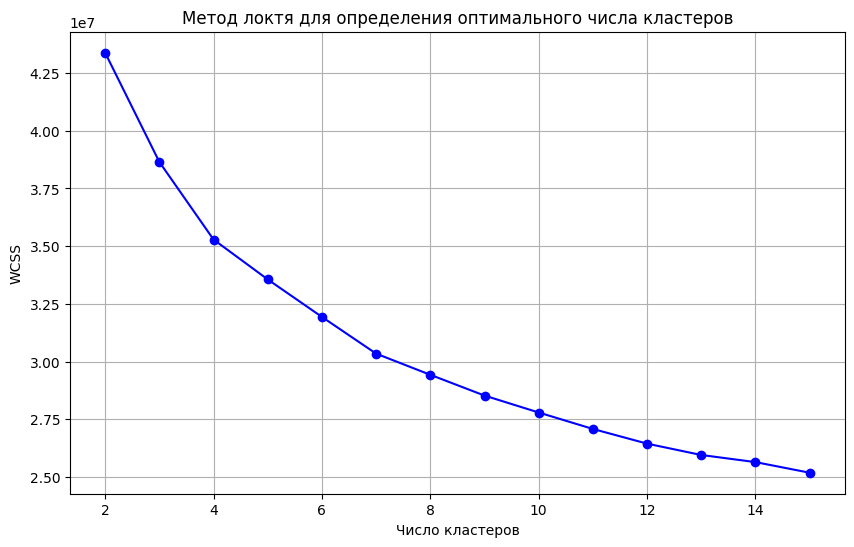

In [41]:
wcss = []
# Возьмём 15 классов, предполагая, что мы не знаем что их всего 10
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca_95)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 16), wcss, 'bo-')
plt.xlabel('Число кластеров')
plt.ylabel('WCSS')
plt.title('Метод локтя для определения оптимального числа кластеров')
plt.grid(True)
plt.show()

На графике видно, что нет явного "локтя", поэтому возьмём примерно число 8, тк после него идёт более прямая линия (на глазок). Хоть мы и знаем что классов всего 10, но PCA и K-Means нет

## Проведём оценку связи кластеров с метками классов на изображениях

In [42]:
optimal_k = 8

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_pca_95)

cross_tab = pd.crosstab(
    index=cluster_labels,
    columns=y,
    margins=True,
    margins_name='Всего'
)

cross_tab_norm_rows = pd.crosstab(
    index=cluster_labels,
    columns=y,
    normalize='index'
) * 100

clean_clusters = []
for cluster in range(optimal_k):
    row = cross_tab_norm_rows.loc[cluster]
    max_class = row.idxmax()
    max_percent = row.max()

    if max_percent > 70:
        clean_clusters.append((cluster, max_class, max_percent))
        print(f"Кластер {cluster}: {max_class} = {max_percent:.1f}% (ЧИСТЫЙ)")
    else:
        top2 = row.nlargest(2)
        print(f"Кластер {cluster}: смешанный")

print(f"\nИтого: {len(clean_clusters)} чистых кластеров из {optimal_k}")

print("\n" + "="*60)

cross_tab_norm_cols = pd.crosstab(
    index=cluster_labels,
    columns=y,
    normalize='columns'
) * 100

print("Процентное распределение кластеров для каждого класса:")
print(cross_tab_norm_cols.round(1))
print("\n" + "-"*60)

concentrated_classes = []
for true_class in y.unique():
    col = cross_tab_norm_cols[true_class]
    max_cluster = col.idxmax()
    max_percent = col.max()

    if max_percent > 50:
        concentrated_classes.append((true_class, max_cluster, max_percent))
        print(f"  + Класс '{true_class}': {max_percent:.1f}% в кластере {max_cluster} (СКОНЦЕНТРИРОВАН)")
    else:
        top2 = col.nlargest(2)
        print(f"  - Класс '{true_class}': рассредоточен")
        print(f"    Основной кластер {top2.index[0]}: {top2.values[0]:.1f}%")
        print(f"    Второй кластер {top2.index[1]}: {top2.values[1]:.1f}%")


Кластер 0: смешанный
Кластер 1: Ankle boot = 85.5% (ЧИСТЫЙ)
Кластер 2: смешанный
Кластер 3: смешанный
Кластер 4: смешанный
Кластер 5: Bag = 91.0% (ЧИСТЫЙ)
Кластер 6: Bag = 91.7% (ЧИСТЫЙ)
Кластер 7: смешанный

Итого: 3 чистых кластеров из 8

Процентное распределение кластеров для каждого класса:
class  Ankle boot   Bag  Coat  Dress  Pullover  Sandal  Shirt  Sneaker  \
row_0                                                                    
0             0.2   2.5  63.5    0.8      64.3     0.0   35.6      0.0   
1            84.1   0.5   0.0    0.0       0.0     8.9    0.0      4.8   
2             2.5  11.0  15.6   18.1      30.2    32.9   38.5      0.7   
3             0.1   0.4   3.5   53.5       0.2     0.0    1.3      0.0   
4            12.6   7.4   0.0    0.0       0.1    57.9    0.2     94.5   
5             0.1  40.5   0.9    0.1       1.5     0.2    0.8      0.0   
6             0.0  36.7   0.2    0.0       0.5     0.0    1.6      0.0   
7             0.4   0.8  16.3   27.4  

## Вывод
На основании оценки связи кластеров и классов можно сказать, что большая часть классов неверно распределены по кластерам, это связано с тем, что локоть оказался равен всего 8, а не 10 (как должен был быть). Однако стоит учесть, что даже при локте 8 данные не так уж и плохо распределились (много классов, где больше 50% класса находятся в одном кластере). Считаю свою первую работу по кластеризации довольно успешной и уверен, что достоин всех 10 баллов из 10 (я старалься).